In [31]:
import psi4
import numpy as np
import datetime
from scipy import linalg as splinalg

In [32]:
psi4.set_memory('500 MB')
numpy_memory = 2
psi4.core.set_output_file('output.dat', False)
basis = '6-31g(d)'
psi4.set_options({'basis': basis,
                  'scf_type': 'pk',
                  'e_convergence': 1e-8})
mol = psi4.geometry("""
5

C    0.00000000  0.00000000  0.00000000
H    0.00000000 -0.88480900 -0.62565400
H   -0.00000000  0.88480900 -0.62565400
H   -0.88480900  0.00000000  0.62565400
H    0.88480900  0.00000000  0.62565400
""")
SCF_E_psi = psi4.energy('scf')
psi4.core.clean()
print(f"The Hartree-Fock ground state energy of the water is: {SCF_E_psi:.6f} Eh")

The Hartree-Fock ground state energy of the water is: -40.195172 Eh


In [33]:
wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))
ndocc = wfn.nalpha()
nbf = wfn.basisset().nbf()
mints = psi4.core.MintsHelper(wfn.basisset())
S_matrix = mints.ao_overlap()
S = np.asarray(S_matrix) 
#Testing for orthonormality
def isBasisOrthonormal(S):
    size_S = S.shape[0] 
    identity_matrix = np.eye(size_S) 
    orthonormal_check = np.allclose(S, identity_matrix)
    print(F'Q:(T/F) The AO basis is orthonormal? A: {orthonormal_check}')
    return orthonormal_check
A = splinalg.sqrtm(np.linalg.inv(S))
S_p = A.dot(S.dot(A))
T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
H = T + V
F_p = A.dot(H.dot(A))
vals, vecs = np.linalg.eigh(F_p)
C=A.dot(vecs)
C_occ = C[:, :ndocc]
D = np.einsum('pi,qi->pq',C_occ ,C_occ )
I = np.asarray(mints.ao_eri())
J = np.einsum('rs,pqrs->pq',D,I )
K = np.einsum('rq,pqrs->ps',D,I )
F = H + 2*J - K
isBasisOrthonormal(S_p)

Q:(T/F) The AO basis is orthonormal? A: True


True

In [34]:
start_time = datetime.datetime.now()
# ==> Nuclear Repulsion Energy <==
E_nuc = mol.nuclear_repulsion_energy()

# ==> SCF Iterations <==
SCF_E = 0.0
E_old = 0.0
MAXITER = 40
E_conv = 1.0e-8

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    I = np.asarray(mints.ao_eri())
    J = np.einsum('rs,pqrs->pq',D,I )
    K = np.einsum('rq,pqrs->ps',D,I )
    F = H + 2*J - K    
    SCF_E = E_nuc + np.einsum('pq->',(H+F)*(D))
    print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
    if (abs(SCF_E - E_old) < E_conv):
        break
    E_old = SCF_E
    F_p=A.dot(F.dot(A))
    vals, vecs = np.linalg.eigh(F_p)
    C=A.dot(vecs)
    C_occ = C[:, :ndocc]
    D = np.einsum('pi,qi->pq',C_occ ,C_occ ) 
    if (scf_iter == MAXITER):
        psi4.core.clean()
        raise Exception("Maximum number of SCF iterations exceeded.")

# Post iterations
print('\nSCF converged.')
print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')
end_time = datetime.datetime.now()
print("This took %f seconds" %(end_time-start_time).total_seconds())

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -32.63726674 dE = -32.63726674
SCF Iteration 2: Energy = -37.38707223 dE = -4.74980549
SCF Iteration 3: Energy = -39.30045787 dE = -1.91338564
SCF Iteration 4: Energy = -40.02417358 dE = -0.72371571
SCF Iteration 5: Energy = -40.16482105 dE = -0.14064746
SCF Iteration 6: Energy = -40.19016280 dE = -0.02534175
SCF Iteration 7: Energy = -40.19434476 dE = -0.00418196
SCF Iteration 8: Energy = -40.19503599 dE = -0.00069123
SCF Iteration 9: Energy = -40.19514954 dE = -0.00011356
SCF Iteration 10: Energy = -40.19516824 dE = -0.00001869
SCF Iteration 11: Energy = -40.19517131 dE = -0.00000307
SCF Iteration 12: Energy = -40.19517182 dE = -0.00000051
SCF Iteration 13: Energy = -40.19517190 dE = -0.00000008
SCF Iteration 14: Energy = -40.19517191 dE = -0.00000001
SCF Iteration 15: Energy = -40.19517192 dE = -0.00000000

SCF converged.
Final RHF Energy: -40.195172 [Eh]
This took 0.740000 seconds


In [35]:
import datetime
start_time = datetime.datetime.now()
SCF_E_psi = psi4.energy('SCF')
end_time = datetime.datetime.now()
psi4.core.clean()
assert psi4.compare_values(SCF_E_psi, SCF_E, 8, 'My SCF Procedure')
print("Psi4 calculations took %f seconds" %(end_time-start_time).total_seconds())

    My SCF Procedure......................................................................PASSED
Psi4 calculations took 0.333000 seconds


In [38]:
#HF,H2O,NH3,CH4,H2S in minimal Basis Set STO-3G
psiTime=[0.193001,0.218000,0.237000,0.306002,0.232999]
meTime=[0.011997,0.034001,0.052000,0.062002,0.100998 ]
#HF,H2O,NH3,CH4,H2S in 6-31g(d) Basis Set
psit=[0.217003,0.262000,0.267002,0.333000,0.274001]
met=[0.218998,0.410999,0.643001,0.740000,0.900000]

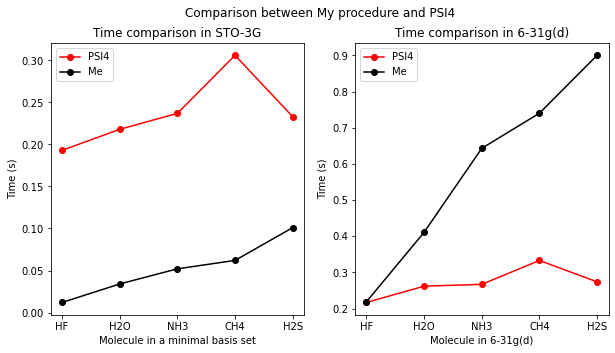

In [39]:
import matplotlib.pyplot as plt

x = ['HF','H2O','NH3','CH4','H2S']
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Comparison between My procedure and PSI4')
ax1.plot(x,psiTime,'ro-',label="PSI4")
ax1.plot(x,meTime,'ko-',label="Me")
ax1.set_title('Time comparison in STO-3G')
ax1.set(xlabel='Molecule in a minimal basis set',ylabel='Time (s)')
ax1.legend()
ax2.plot(x,psit,'ro-',label="PSI4")
ax2.plot(x,met,'ko-',label="Me")
plt.xlabel('Molecule in a minimal basis set')
plt.ylabel('Time (s)')
ax2.set_title('Time comparison in 6-31g(d)')
ax2.set(xlabel='Molecule in 6-31g(d)',ylabel='Time (s)')
ax2.legend()
plt.savefig('tcomp.pdf') 
plt.show()